<span style="font-size:36px"><b>Baseline Model Tutorial</b></span>

Copyright &copy; 2020 Gunawan Lumban Gaol

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language overning permissions and limitations under the License.

# Import Packages

In [19]:
import sys
import glob

import numpy as np
import pandas as pd
from IPython.core.display import display, HTML
import tensorflow as tf
import tensorflow.keras.backend as K
print("tf.__version__ = "+tf.__version__)

from gurih.data.data_generator import DataGenerator
from gurih.models.model import BaselineASRModel
from gurih.models.model_utils import CharMap, ctc_decode, wer

%load_ext autoreload
%autoreload 2

tf.__version__ = 2.1.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train Model

Define constant for ASR Model.

In [20]:
CHAR_TO_IDX_MAP = CharMap.CHAR_TO_IDX_MAP
IDX_TO_CHAR_MAP = CharMap.IDX_TO_CHAR_MAP

MAX_SEQ_LENGTH = 3000
MAX_LABEL_LENGTH = 300
BATCH_SIZE = 16
MAX_EPOCHS = 5000

Create and compile keras model.

In [21]:
BaselineASR = BaselineASRModel(input_shape=(MAX_SEQ_LENGTH, 39), vocab_len=len(CharMap()))
BaselineASR.compile()

Model directory is set to ../../models/
Documentation directory is set to ../../docs/

Model: "BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 3000, 39)]        0         
_________________________________________________________________
masking (Masking)            (None, 3000, 39)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1495, 200)         86000     
_________________________________________________________________
bidirectional (Bidirectional (None, 1495, 400)         641600    
_________________________________________________________________
the_output (TimeDistributed) (None, 1495, 30)          12030     
Total params: 739,630
Trainable params: 739,630
Non-trainable params: 0
_________________________________________________________

Get model output sequence length for ctc input. This is required as we are using custom `Lambda` layer inside model.

In [22]:
CTC_INPUT_LENGTH = BaselineASR.model.get_layer('the_output').output.shape[1]
CTC_INPUT_LENGTH

1495

## Train using `fit_generator()`

Prepare data using `DataGenerator`.

In [23]:
train_dir = "../../dataset/interim/Model-010a/train/"
valid_dir = "../../dataset/interim/Model-010a/valid/"
# test_dir = "../../test/test_data/data_generator/"

Directories must contain all `.npz` and `.txt` files required for `DataGenerator`.

In [24]:
train_generator = DataGenerator(input_dir=train_dir,
                                max_seq_length=MAX_SEQ_LENGTH,
                                max_label_length=MAX_LABEL_LENGTH,
                                ctc_input_length=CTC_INPUT_LENGTH,
                                char_to_idx_map=CHAR_TO_IDX_MAP,
                                batch_size=BATCH_SIZE)

validation_generator = DataGenerator(input_dir=valid_dir,
                                     max_seq_length=MAX_SEQ_LENGTH,
                                     max_label_length=MAX_LABEL_LENGTH,
                                     ctc_input_length=CTC_INPUT_LENGTH,
                                     char_to_idx_map=CHAR_TO_IDX_MAP,
                                     batch_size=BATCH_SIZE)

Fit model. Pass validation generator if using `EarlyStopping` and `ModelCheckpoint` callbacks.

In [25]:
BaselineASR._callbacks(min_delta=1e-4, patience=50)

In [26]:
BaselineASR.fit_generator(train_generator=train_generator,
                          validation_generator=validation_generator,
                          epochs=MAX_EPOCHS)

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 37 steps, validate for 25 steps
Epoch 1/5000
37/37 [==============================] - 468s 13s/step - loss: 1413.5064 - val_loss: 1155.1588
Epoch 2/5000
37/37 [==============================] - 477s 13s/step - loss: 1061.9293 - val_loss: 1072.1651
Epoch 3/5000
37/37 [==============================] - 446s 12s/step - loss: 1004.9710 - val_loss: 1036.3027
Epoch 4/5000
37/37 [==============================] - 484s 13s/step - loss: 953.8460 - val_loss: 938.3067
Epoch 5/5000
37/37 [==============================] - 420s 11s/step - loss: 754.2203 - val_loss: 729.0567
Epoch 6/5000
37/37 [==============================] - 449s 12s/step - loss: 696.4800 - val_loss: 719.6434
Epoch 7/5000
37/37 [==============================] - 499s 13s/step - loss: 691.0630 - val_loss: 711.2839
Epoch 8/5000
37/37 [==============================] - 451s 12s/step - loss: 681.7589 - val_loss: 696.3371
Epoch 9/5000
37/37 [============

See training plots.

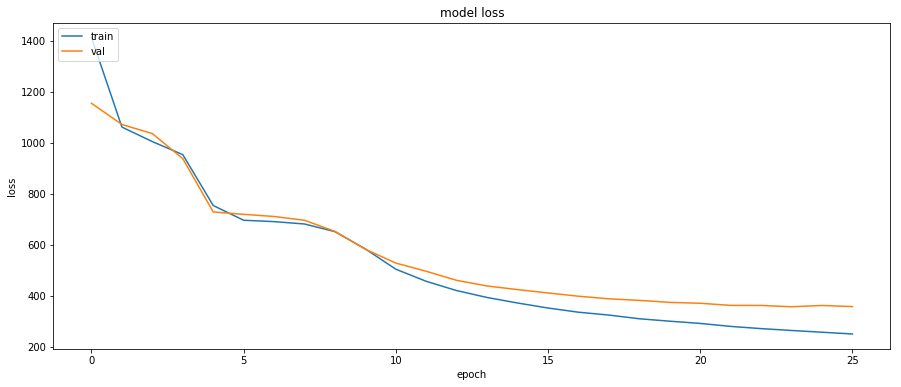

In [27]:
BaselineASR.plot_history()

Evaluate using test data.

In [102]:
test_generator = DataGenerator(input_dir=test_dir,
                                max_seq_length=MAX_SEQ_LENGTH,
                                max_label_length=MAX_LABEL_LENGTH,
                                ctc_input_length=CTC_INPUT_LENGTH,
                                char_to_idx_map=CHAR_TO_IDX_MAP,
                                batch_size=2,
                                shuffle=False) # set to False to ensure correct alignment between y_true and y_pred

X_test = test_generator[0][0]['the_input']
X_test.shape

(2, 2500, 39)

In [103]:
ctc_matrix = BaselineASR.predict(X_test)
ctc_matrix.shape

(2, 1245, 30)

Calculate and display word error rate.

In [104]:
def get_y(filename):
    with open(filename, 'r') as f:
        return f.readline()

In [105]:
txts = sorted(glob.glob(test_dir+"*.txt"))

y_true = [get_y(txt) for txt in txts]
y_pred = ctc_decode(ctc_matrix, IDX_TO_CHAR_MAP, greedy=False)

In [126]:
word_error_rate = wer(y_true, y_pred)
print('WER %.4f %%' % word_error_rate)

WER 3.5714 %


Display prediction errors. 
* Red colors are <span style="background-color:rgba(255, 0, 0, 0.23)">missing word</span>
* Green colors are <span style="background-color:rgba(0, 128, 0, 0.23)">insertion word</span>.
* Yellow colors are <span style="background-color:rgba(255, 165, 0, 0.5)">substitution word</span> and the references are in parenthesis.

In [130]:
_ = wer(y_true[0], y_pred[0], write_html=True)

In [131]:
with open("diff.html", 'r') as f:
    html = f.readlines()[0]
display(HTML(html))